# Import Library

In [170]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
data_path = '../Dogs-vs-cats/data'
print(os.listdir(data_path))

['.DS_Store', 'test', 'sampleSubmission.csv', 'train']


# Define Constants

In [198]:
FAST_RUN = False
IMG_HEIGHT = 80
IMG_WIDTH = 80
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_CHANNELS = 3

# Prepare Training Data

In [183]:
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

filenames = os.listdir(train_path)
categories = []
convert = lambda category : int(category == 'dog')
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(convert(category))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [184]:
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


In [185]:
df.tail()

,filename,category
24995,dog.8008.jpg,1
24996,dog.1992.jpg,1
24997,dog.12412.jpg,1
24998,cat.2701.jpg,0
24999,cat.10148.jpg,0


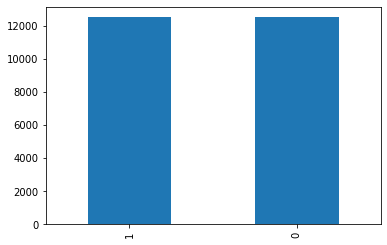

In [186]:
df['category'].value_counts().plot.bar()

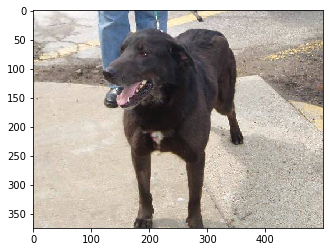

In [191]:
sample = random.choice(filenames)
image = load_img(os.path.join(train_path, sample))
plt.imshow(image)

# Build Model

In [207]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 78, 78, 32)        896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 78, 78, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 37, 37, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 18, 18, 64)      

# Callbacks

In [236]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [237]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

In [211]:
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'})

In [212]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

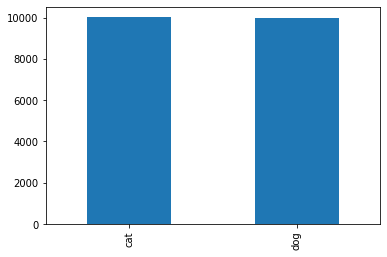

In [214]:
train_df['category'].value_counts().plot.bar()

In [218]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

# Training Generator

In [219]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255, 
                                   shear_range=0.1, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    train_path, 
                                                    x_col='filename', 
                                                    y_col='category', 
                                                    target_size=IMG_SIZE, 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


# Validation Generator

In [225]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              train_path, 
                                                              x_col='filename',
                                                              y_col='category',
                                                              target_size=IMG_SIZE,
                                                              class_mode='categorical',
                                                              batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


# How our generator work

In [226]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(example_df,
                                                      train_path,
                                                      x_col='filename',
                                                      y_col='category',
                                                      target_size=IMG_SIZE,
                                                      class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


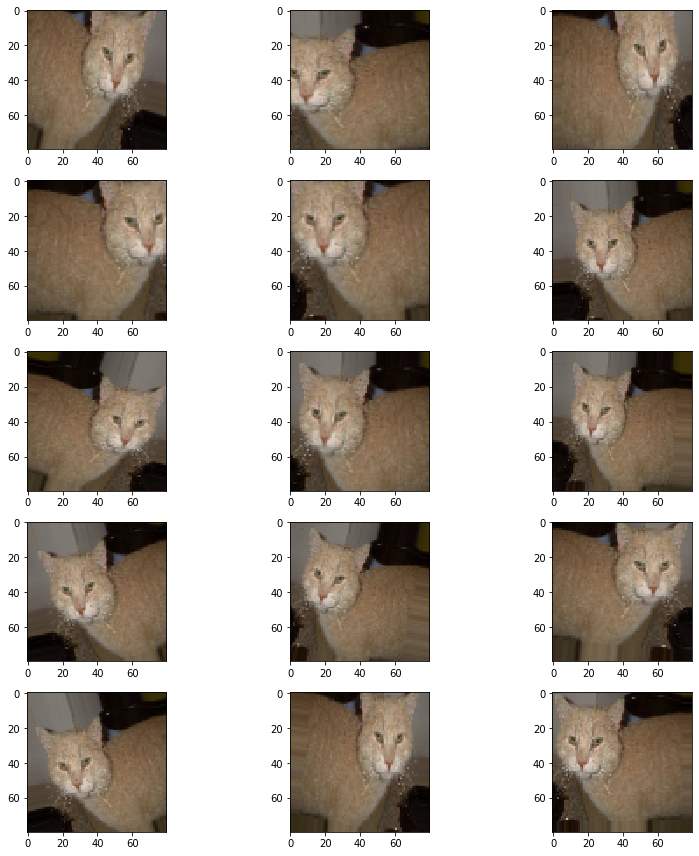

In [234]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, _ in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [238]:
epochs = 3 if FAST_RUN else 50
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              validation_data=validation_generator, 
                              validation_steps=total_validate//batch_size,
                              steps_per_epoch=total_train//batch_size,
                              callbacks=callbacks)

Epoch 1/50
1333/1333 [==============================] - 572s 429ms/step - loss: 0.6263 - accuracy: 0.6617 - val_loss: 1.1458 - val_accuracy: 0.5624
Epoch 2/50
1333/1333 [==============================] - 527s 395ms/step - loss: 0.5918 - accuracy: 0.6942 - val_loss: 0.6667 - val_accuracy: 0.6826
Epoch 3/50
1333/1333 [==============================] - 475s 357ms/step - loss: 0.5649 - accuracy: 0.7075 - val_loss: 0.4789 - val_accuracy: 0.7751
Epoch 4/50
1333/1333 [==============================] - 738s 554ms/step - loss: 0.5560 - accuracy: 0.7188 - val_loss: 0.8177 - val_accuracy: 0.5970
Epoch 5/50
1333/1333 [==============================] - 569s 427ms/step - loss: 0.5301 - accuracy: 0.7367 - val_loss: 0.5932 - val_accuracy: 0.6832

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
1333/1333 [==============================] - 513s 385ms/step - loss: 0.4925 - accuracy: 0.7614 - val_loss: 0.8084 - val_accuracy: 0.8028
Epoch 7/50
1333/1333 [=========

In [239]:
model.save_weights('model.h5')

# Visualize

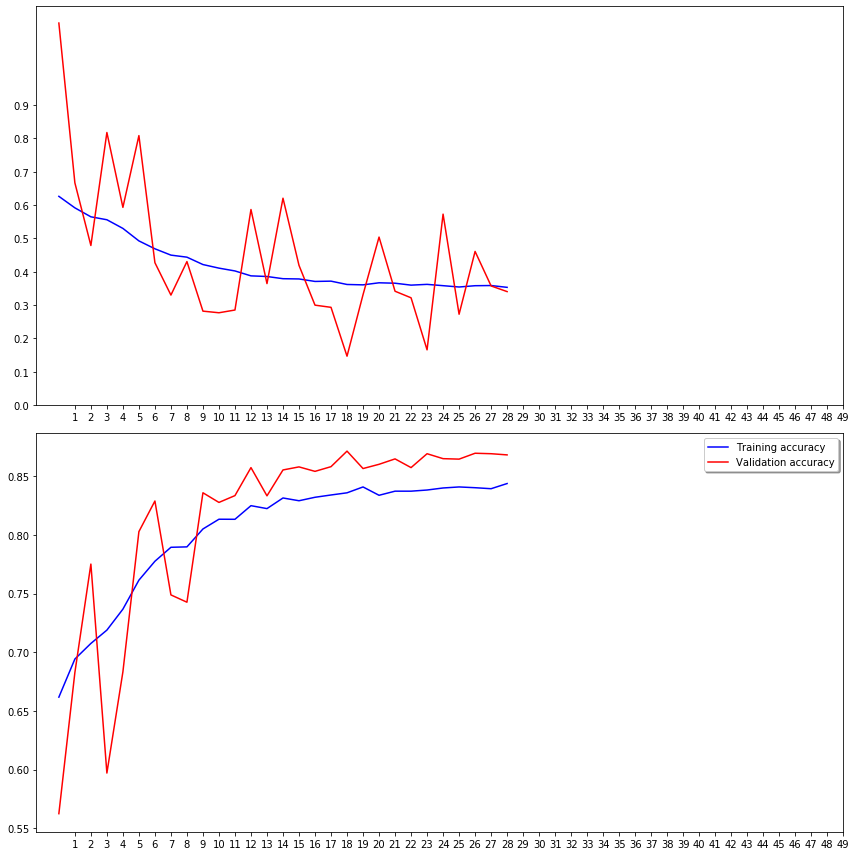

In [243]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(shadow=True)
plt.tight_layout()
plt.show()

# Prepare testing data

In [244]:
test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({'filename': test_filenames})
nb_samples = test_df.shape[0]

# Create testing generator


In [248]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    test_path,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


TypeError: 'ImageDataGenerator' object is not subscriptable

# Predict

In [249]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [250]:
test_df['category'] = np.argmax(predict, axis=-1)

In [251]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [252]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

# Virtualize result

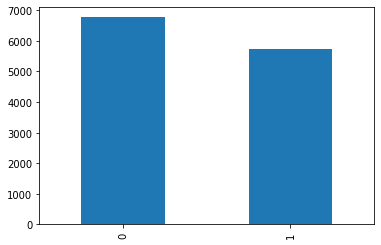

In [253]:
test_df['category'].value_counts().plot.bar()

# Predicted result

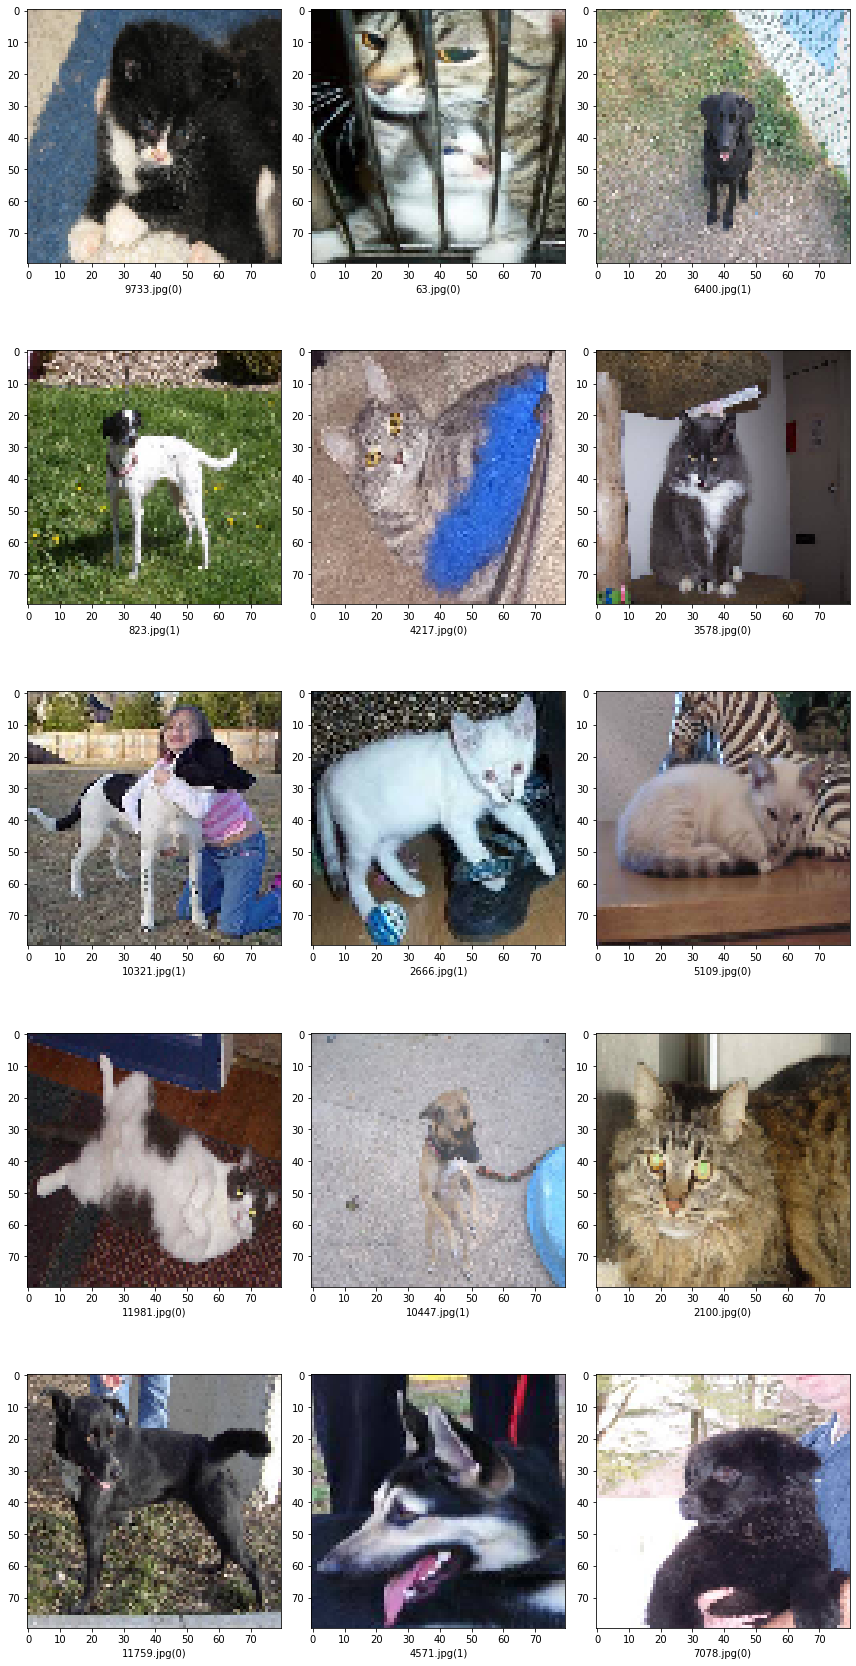

In [254]:
sample_test = test_df.head(15)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(os.path.join(test_path, filename), target_size=IMG_SIZE)
    plt.subplot(5, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '({0})'.format(category))
plt.tight_layout()
plt.show()

In [255]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)